In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import h5py
import os
import scipy.stats as stats
from scipy.special import gamma as gammafunc
from scipy.special import logsumexp
import stan
import arviz as az
import nest_asyncio
nest_asyncio.apply()

In [2]:
from general_model import temporally_augment, filter_data_by_dict, temporal_aggregation, bin_data, model_sample, stan_sample, sampling_visualisation, create_quantile_table
from hypothesis_testing import chib_marginal_likelihood, null_hypothesis_sample, logistic_chib_marginal_likelihood

In [3]:
project_dir = '/data/florican/jamiesonball/Intern_Project'

data_dir = os.path.join(project_dir, 'data')
data_filepath = os.path.join(data_dir, 'BGD_daily_inc_fatalities.h5')

data = pd.read_hdf(data_filepath,
                   key='event_data')

data = temporally_augment(data)

### Likelihoods are defined here

The below cell contains the null and model 4 prior likelihoods, prior distributions for sampling, and the log likelihood functions.

In [4]:
def null_hyp_log_lik(probability, responses, observations):
    lhood_list = []
    for count, fatal in zip(observations, responses):
        prob = 1 - np.exp(count*np.log(1-probability))
        lhood_list.append(fatal * np.log(prob) + (1-fatal) * np.log(1-prob))
    return np.nansum(lhood_list)

def model4_log_lik(parameters, responses, observations):
    probabilities = mod4_transform_parameters(parameters[0], parameters[1:])
    lhood_list = []
    for cov, fatal in zip(observations, responses):
        prob = probabilities[cov-1]
        lhood_list.append(fatal * np.log(prob) + (1-fatal) * np.log(1-prob))
    return np.sum(lhood_list)

def null_prior_lhood(param, hyperparams):
    return stats.beta.logpdf(param, hyperparams[0], hyperparams[1])

def mod4_prior_lhood(params, hyperparams):
    total_sum = 0
    for idx, param in enumerate(params):
        total_sum += stats.beta.logpdf(param, hyperparams[idx][0], hyperparams[idx][1])
    return total_sum

def mod4_transform_parameters(max_p, q_list):
    prob_list = [max_p]
    for i in range(len(q_list)):
        max_p *= q_list[i]
        prob_list.append(max_p)
    prob_list.reverse()
    return prob_list

def mod4_prior_dist(max_bin):
    priors = []
    for _ in range(max_bin):
        priors.append(np.random.beta(1, 1))
    return priors

def null_hyp_prior_dist(max_bin):
    return np.random.beta(1,1)

In [5]:
def null_hyp_log_lik(probability, responses, observations):
    lhood_list= []
    for count, fatal in zip(observations, responses):
        prob = 1 - (1-probability)**count
        lhood_list.append(fatal * np.log(prob) + (1-fatal) * np.log(1-prob))
    return np.nansum(lhood_list)

In [6]:
from mcmc_functions import logit_ll, mod6_llh
from general_model import model_observations, model_sample
from hypothesis_testing import harmonic_mean_marginal_likelihood

In [7]:
data_filter = {'ADM2_name':'Dhaka',
               'EVENT_TYPE':'Battles'}

stan_filepath = 'stan_files/model1.stan'

In [8]:
model, samples_1 = model_sample(1, data, data_filter, stan_filepath=stan_filepath, stan_seed=1)

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000102 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.02 seconds.
  Adjust your expectations accordingly!


In [9]:
responses, covariates = model_observations(1, data, data_filter, stan_filepath=True, ignore_zero=True)

In [10]:
marg_1 = harmonic_mean_marginal_likelihood(samples_1[['alpha', 'beta_']].values, logit_ll, responses, covariates)

In [11]:
marg_1

-70.96172861520918

This section is an attempt to use the iterative scheme presented by Newton and Raftery in 1994. We define

\begin{equation}
    \hat p_4(X) = \frac{\frac{\delta m}{1-\delta} + \sum_{i=1}^m\frac{p(X|\theta_i)}{\delta \hat p_4(X) + (1-\delta) p(X|\theta_i)}}{\frac{\delta m}{1-\delta} \hat p_4(X) + \sum_{i=1}^m \left(\delta \hat p_4(X) +(1-\delta)p(X|\theta_i)\right)^{-1}}
\end{equation}

In [12]:
# def nr4_marginal_likelihood(samples, likelihood, responses, covariates, delta, iterations, convergence_diagnostic=True):
#     if iterations == 0:
#         return 1
#     m = len(samples)
#     prev_iter = nr4_marginal_likelihood(samples, likelihood, responses, covariates, delta, iterations-1, convergence_diagnostic)
#     log_likelihoods = [likelihood(sample, responses, covariates) for sample in samples]

#     # first term
#     term1 = np.log(delta) + np.log(m) - np.log(1-delta)

#     # second term of the equation
#     term2_logs = [ll - logsumexp([np.log(delta) + prev_iter, np.log(1-delta) + ll]) for ll in log_likelihoods]
#     term2 = logsumexp(term2_logs)

#     # third term
#     term3 = term1 + prev_iter

#     # fourth term
#     term4_logs = [-logsumexp([np.log(delta) + prev_iter, np.log(1-delta) + ll]) for ll in log_likelihoods]
#     term4 = logsumexp(term4_logs)

#     numerator = logsumexp([term1, term2])
#     denominator = logsumexp([term3, term4])
#     if convergence_diagnostic:
#         print(f'estimate in iteration {iterations} of {numerator-denominator}')
#     return numerator - denominator

In [13]:
def nr4_marginal_likelihood(samples, likelihood, responses, covariates, delta, initial_value=0, error=1e-2, convergence_diagnostic=False):
    marg_lik_estimates = [initial_value]
    m = len(samples)
    log_likelihoods = [likelihood(sample, responses, covariates) for sample in samples]

    # first term
    term1 = np.log(delta) + np.log(m) - np.log(1-delta)

    # second term of the equation
    term2_logs = [ll - logsumexp([np.log(delta) + initial_value, np.log(1-delta) + ll]) for ll in log_likelihoods]
    term2 = logsumexp(term2_logs)

    # third term
    term3 = term1 + initial_value

    # fourth term
    term4_logs = [-logsumexp([np.log(delta) + initial_value, np.log(1-delta) + ll]) for ll in log_likelihoods]
    term4 = logsumexp(term4_logs)

    numerator = logsumexp([term1, term2])
    denominator = logsumexp([term3, term4])

    marg_lik_estimates.append(numerator-denominator)

    while abs(marg_lik_estimates[-2] - marg_lik_estimates[-1]) > error:
        prev_iter = marg_lik_estimates[-1]
        # second term of the equation
        term2_logs = [ll - logsumexp([np.log(delta) + prev_iter, np.log(1-delta) + ll]) for ll in log_likelihoods]
        term2 = logsumexp(term2_logs)

        # third term
        term3 = term1 + prev_iter

        # fourth term
        term4_logs = [-logsumexp([np.log(delta) + prev_iter, np.log(1-delta) + ll]) for ll in log_likelihoods]
        term4 = logsumexp(term4_logs)

        numerator = logsumexp([term1, term2])
        denominator = logsumexp([term3, term4])

        marg_lik_estimates.append(numerator-denominator)
        if convergence_diagnostic:
            print(f'Estimate in iteration {len(marg_lik_estimates)-1} of {marg_lik_estimates[-1]}')
    return marg_lik_estimates[-1]

In [14]:
samples_1 = samples_1[['alpha', 'beta_']].values

In [15]:
nr4_marg_lik1 = nr4_marginal_likelihood(samples_1, logit_ll, responses, covariates, initial_value=-100, delta=0.1, convergence_diagnostic=True)

Estimate in iteration 2 of -68.44093856969602
Estimate in iteration 3 of -67.82168529300192
Estimate in iteration 4 of -67.6495761184631
Estimate in iteration 5 of -67.60023049681942
Estimate in iteration 6 of -67.5859568771515
Estimate in iteration 7 of -67.58181762544419


In [16]:
nr4_marg_lik1 = nr4_marginal_likelihood(samples_1, logit_ll, responses, covariates, initial_value=0, delta=0.1, convergence_diagnostic=True)

Estimate in iteration 2 of -9.010670518605796
Estimate in iteration 3 of -13.510480189101706
Estimate in iteration 4 of -18.010289859431992
Estimate in iteration 5 of -22.510099529762257
Estimate in iteration 6 of -27.009909200092522
Estimate in iteration 7 of -31.509718870422788
Estimate in iteration 8 of -36.009528540752946
Estimate in iteration 9 of -40.50933821107427
Estimate in iteration 10 of -45.0091478806003
Estimate in iteration 11 of -49.508957478549505
Estimate in iteration 12 of -54.00876063461417
Estimate in iteration 13 of -58.50798425876423
Estimate in iteration 14 of -62.956885010608104
Estimate in iteration 15 of -66.03482686912984
Estimate in iteration 16 of -67.10507245615007
Estimate in iteration 17 of -67.43961230868331
Estimate in iteration 18 of -67.53910658600708
Estimate in iteration 19 of -67.56819823183817
Estimate in iteration 20 of -67.57666116089447


In [17]:
nr4_marg_lik1

-67.57666116089447

In [18]:
data_filter = {'ADM2_name':'Dhaka',
               'EVENT_TYPE':'Battles'}

In [19]:
filtered_data = filter_data_by_dict(data, data_filter)
agg_data = temporal_aggregation(filtered_data, 'WEEK')
bins = [i for i in range(3 + 1)]
bins.append(float(('inf')))
agg_data = bin_data(agg_data, bins=bins)
fatality_flag = agg_data['FATALITY_FLAG'].values
event_bins = agg_data['BINS'].values.astype(int)
num_obs = len(fatality_flag)

responses = np.array([flag for flag, cov in zip(fatality_flag, event_bins) if cov > 0])
covariates = np.array([cov for cov in event_bins if cov > 0])

In [21]:
model, full_chain_4 = model_sample(4, data, data_filter, 10000, stan_filepath='stan_files/model4.stan', max_bin=3)

samples_4 = full_chain_4[['pK', 'q.2', 'q.1']].values

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/108000)
Sampling:   0% (2/108000)
Sampling:  25% (27002/108000)
Sampling:  50% (54002/108000)
Sampling:  75% (81001/108000)
Sampling: 100% (108000/108000)
Sampling: 100% (108000/108000), done.
Messages received during sampling:
  Gradient evaluation took 0.000108 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!


In [22]:
model, full_chain_6 = model_sample(6, data, data_filter, stan_filepath='stan_files/model6.stan')
samples_6 = full_chain_6['p'].values

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!


In [23]:
samples_null = model_sample('null', data, data_filter)
samples_null = samples_null['p.1'].values

Sampling directly from the Beta distribution, returning data frame


In [25]:
diagnostic_plot_4 = {'proportion':False, 'limits':[0.0005,0.2], 'length':100}
diagnostic_plot_6 = {'proportion':False, 'limits':[0.0005,0.8], 'length':100}
diagnostic_plot_null = {'proportion':False, 'limits':[0.0005,0.8], 'length':100}

aimed for 2.0% of samples
achieved  2.0%


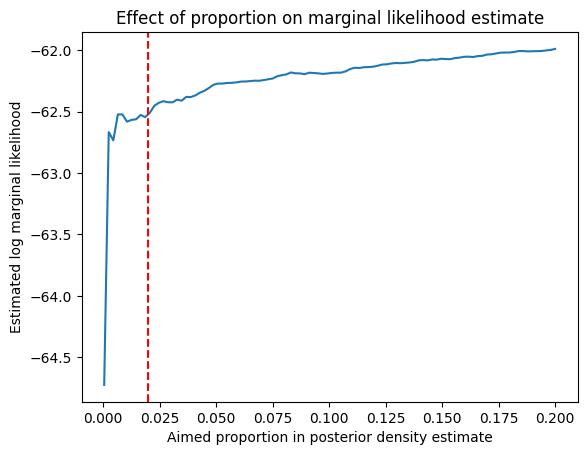

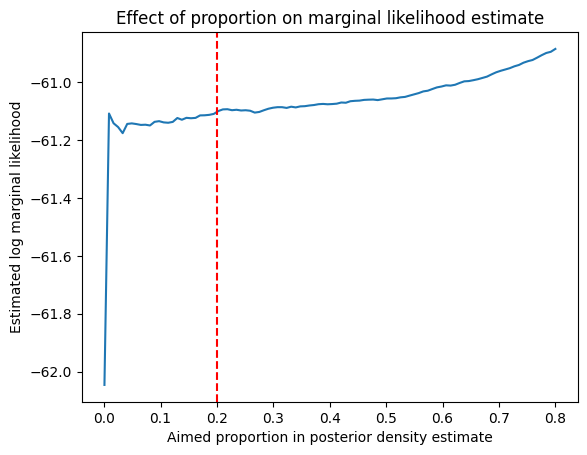

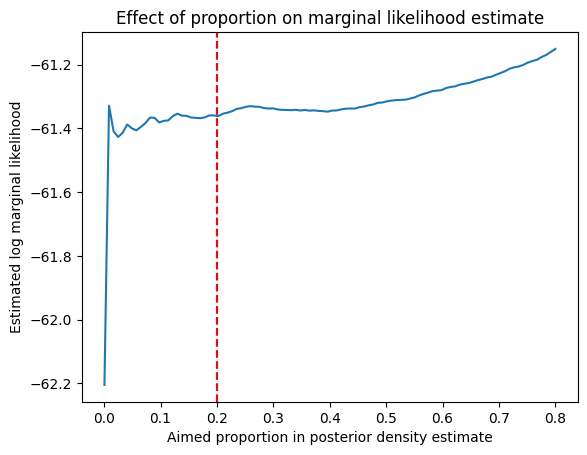

In [26]:
log_marg_lik_4 = chib_marginal_likelihood(samples_4, mod4_prior_lhood, [[1,1],[1,1],[1,1]], model4_log_lik, responses, covariates, target_proportion=0.02, diagnostic_plot=diagnostic_plot_4)
log_marg_lik_6 = chib_marginal_likelihood(samples_6, null_prior_lhood, [1,1], null_hyp_log_lik, responses, covariates, target_proportion=0.2, diagnostic_plot=diagnostic_plot_null)
log_marg_lik_null = chib_marginal_likelihood(samples_null, null_prior_lhood, [1,1], null_hyp_log_lik, responses, covariates, target_proportion=0.2, diagnostic_plot=diagnostic_plot_null)

In [27]:
log_marg_lik_6 - log_marg_lik_4

1.4134327797839816

In [28]:
log_marg_lik_null - log_marg_lik_6

-0.2601415143457615

In [29]:
log_marg_lik_null - log_marg_lik_4

1.1532912654382201

In [30]:
log_marg_lik_6

-61.10224750518815

In [41]:
nr4_marginal_likelihood(samples_6, null_hyp_log_lik, responses, covariates, delta=0.1)

-59.61762555893693

In [43]:
harmonic_mean_marginal_likelihood(samples_null, mod6_llh, responses, covariates)

-65.05349974651726

In [42]:
nr4_marginal_likelihood(samples_null, null_hyp_log_lik, responses, covariates, delta=0.1)

-60.527395256774774

<Axes: ylabel='Density'>

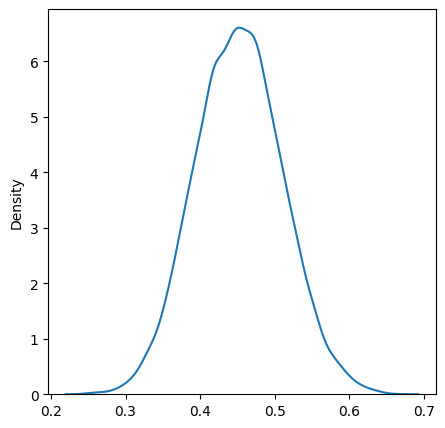

In [33]:
fig, ax = plt.subplots(figsize=(5,5))

sns.kdeplot(samples_null, ax=ax)

In [34]:
log_marg_lik_4

-62.515680284972134

In [36]:
nr4_marginal_likelihood(samples_4, model4_log_lik, responses, covariates, 0.1, 10)

-59.801620320298234

In [37]:
harmonic_mean_marginal_likelihood(samples_4, model4_log_lik, responses, covariates)

-63.42486059172553

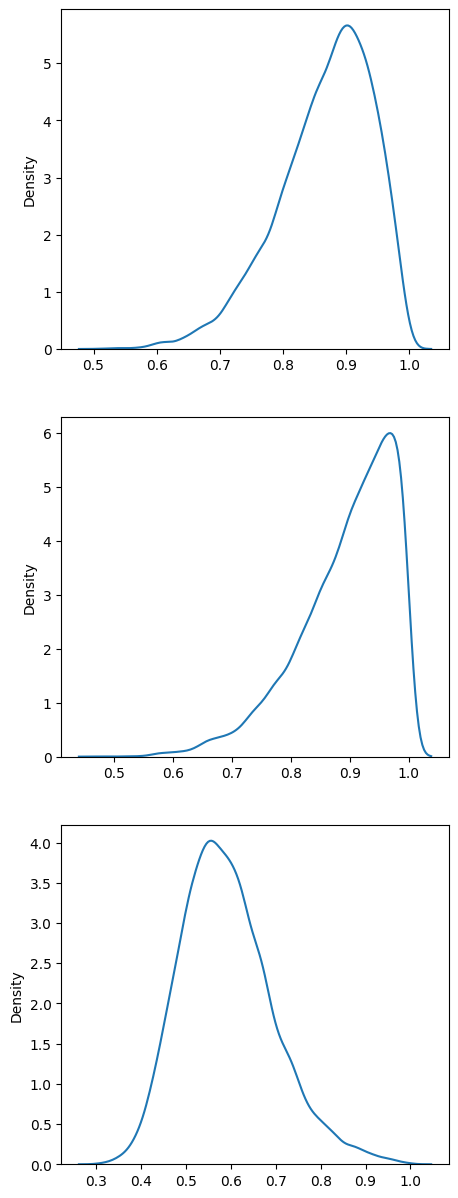

In [38]:
fig, ax = plt.subplots(3, figsize=(5,15))

for idx in range(3):
    sns.kdeplot(samples_4[:,idx], ax=ax[idx])

In [ ]:
covariate_dict = {'inner_events':True,
                  'inner_events_prev':True,
                  'inner_fatal_prev':True,
                  'outer_events':True,
                  'outer_events_prev':False,
                  'outer_fatal':False,
                  'outer_fatal_prev':True}

filter_dict = {'ADM2_name':'Dhaka',
               'EVENT_TYPE':'Battles'}

stan_filepath = 'stan_files/model5.stan'

model, samples_5 = model_sample(5, data, filter_dict, covariates_dict=covariate_dict, stan_filepath=stan_filepath, ignore_zero=True)

: 

In [ ]:
create_quantile_table(samples_5, mean=True)

: 

In [ ]:
diagnostic_plot_5 = {'proportion':False, 'limits':[0.0005,0.05], 'length':100}

: 

In [ ]:
log_marg_lik_5 = logistic_chib_marginal_likelihood(samples_5, data, filter_dict, covariates_dict=covariate_dict, diagnostic_plot=diagnostic_plot_5, ignore_zero=True)

: 

In [ ]:
covariate_dict = {'inner_events':True,
                  'inner_events_prev':True,
                  'inner_fatal_prev':True,
                  'outer_events':True,
                  'outer_events_prev':True,
                  'outer_fatal':False,
                  'outer_fatal_prev':True}

filter_dict = {'ADM2_name':'Dhaka',
               'EVENT_TYPE':'Battles'}

stan_filepath = 'stan_files/model5.stan'

model, samples_6 = model_sample(5, data, filter_dict, covariates_dict=covariate_dict, stan_filepath=stan_filepath, ignore_zero=True)
diagnostic_plot_6 = {'proportion':False, 'limits':[0.0005,0.05], 'length':100}
log_marg_lik_6 = logistic_chib_marginal_likelihood(samples_6, data, filter_dict, covariates_dict=covariate_dict, diagnostic_plot=diagnostic_plot_6, ignore_zero=True)

: 

In [ ]:
covariate_dict = {'inner_events':True,
                  'inner_events_prev':True,
                  'inner_fatal_prev':True,
                  'outer_events':True,
                  'outer_events_prev':True,
                  'outer_fatal':True,
                  'outer_fatal_prev':True}

filter_dict = {'ADM2_name':'Dhaka',
               'EVENT_TYPE':'Battles'}

stan_filepath = 'stan_files/model5.stan'

model, samples_7 = model_sample(5, data, filter_dict, covariates_dict=covariate_dict, stan_filepath=stan_filepath, ignore_zero=True)
diagnostic_plot_7 = {'proportion':False, 'limits':[0.0005,0.05], 'length':100}
log_marg_lik_7 = logistic_chib_marginal_likelihood(samples_7, data, filter_dict, covariates_dict=covariate_dict, diagnostic_plot=diagnostic_plot_7, ignore_zero=True)

: 

In [ ]:
stan_filepath = 'stan_files/model5.stan'
keys = ['inner_events', 'inner_events_prev', 'inner_fatal_prev', 'outer_events', 'outer_events_prev', 'outer_fatal', 'outer_fatal_prev']
parameter_names = [f'beta_.{i}' for i in range(1,8)]
filter_dict = {'ADM2_name':'Dhaka',
               'EVENT_TYPE':'Battles'}
post_means =[]

diagnostic_plot = {'proportion':False, 'limits':[0.0005,0.25], 'length':100}

mod_5_marg_liks = []

for i in range(7):
    bool_list = [False] * 7
    bool_list[i] = True
    covariate_dict = dict(zip(keys, bool_list))
    model, full_chain_model = model_sample(5, data, filter_dict, stan_filepath=stan_filepath, covariates_dict=covariate_dict, ignore_zero=True)
    log_marg_lik = logistic_chib_marginal_likelihood(full_chain_model, data, filter_dict, covariates_dict=covariate_dict, diagnostic_plot=diagnostic_plot, ignore_zero=True)
    mod_5_marg_liks.append(log_marg_lik)
    print(log_marg_lik)

: 